# Problem Statement

SuperCabs, a leading app-based cab provider is looking for retention of good cab drivers in a large Indian metro city. In this highly competitive travel industry, retention of good cab drivers is a crucial business driver.

Most drivers get a healthy number of ride requests from customers throughout the day. But with the recent hikes in electricity prices (all cabs are electric), many drivers complain that although their revenues are gradually increasing, their profits are almost flat. Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day. 

There are some basic rules governing the ride-allocation system. If the cab is already in use, then the driver won’t get any requests. Otherwise, he may get multiple request(s). He can either decide to take any one of these requests or can go ‘offline’, i.e., not accept any request at all.

# Goal

Cab drivers are incentivised by a healthy growth in income. The **goal of this project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field**.

1. **Create the environment**
2. **Build an agent that learns to pick the best request using DQN.**
3. **Convergence**

# Solution

This problem can be solved using a sound RL-based system for assisting cab drivers that can potentially retain and attract new cab drivers.Taking long-term profit as the goal, we propose a method based on reinforcement learning to optimize taxi driving strategies for profit maximization. This optimization problem is formulated as a Markov Decision Process.

We will create the environment and an RL agent that learns to choose the best request. We also need to train an agent using vanilla Deep Q-learning (DQN) 


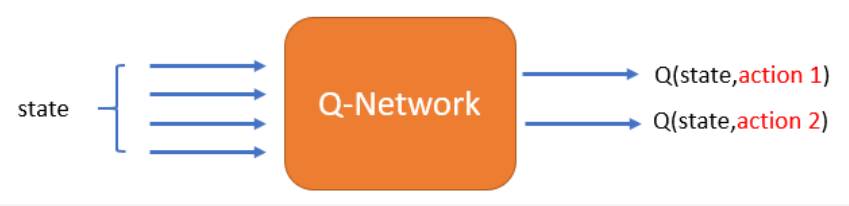

### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix.shape

(5, 5, 24, 7)

In [3]:
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


#### Tracking the state-action pairs for checking convergence


In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
#Defining the agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.0005 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and the action space (0,1) (0,2) (0,3) (0,4).
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, time):
        # Write your code here:
        # Decay in ε after we generate each sample from the environment       
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)

        # Get the requests for the current cab driver state
        possible_actions_index,actions = env.requests(state)

        # get action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return random.choice(possible_actions_index)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            state_encoded = env.state_encod_arch1(state)
            state_value = np.array(state_encoded).reshape(1, self.state_size)
            q_value = self.model.predict(state_value)

            q_value = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_value)]


    def append_sample(self, state, action, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
   
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            #Initialize input of output
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model Q(s,a)
            target = self.model.predict(update_input)
              
            # 2. Get the target for the Q-network Q(s',a)
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch r + gamma * Q(s',a)
            # update the target values
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state 
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [6]:
Episodes = 15000
episode_time=30*24 #30 days before which car has to be recharged
rewards_per_episode, episodes = [], []
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

#initialize the DQN agent
agent = DQNAgent(action_size=action_size, state_size=state_size)    

### DQN block

In [7]:
start_time = time.time()

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    
    # reset at the start of each episode
    # Call all the initialised variables of the environment
    action_size ,state_size,state =  env.reset()
    
    terminal_state = False
    score = 0
    total_time = 0    
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, episode)
        
        # 2. Evaluate your reward and next state
        #next_state,terminal_state  = env.next_state_func(state, action, Time_matrix)
        #reward = env.reward_func(state, action, Time_matrix)
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        
        if(total_time >= episode_time):
            # if battery has to be recharged we have recached terminal state
            terminal_state = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
        
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
        
            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
        # Save the Q_value of the state, action pair we are tracking
        agent.save_tracking_states()
        
    if ((episode + 1) % 100 == 0):
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        # save model weights
        print("Saving Model {}".format(episode))
        agent.save(name="CarPol_model.h5")

elapsed_time = time.time() - start_time
print("Total time : ",elapsed_time/60)

episode 9, reward -366.0, memory_length 1394, epsilon 0.9955101547284723
episode 19, reward 93.0, memory_length 2000, epsilon 0.990545076993076
episode 29, reward -188.0, memory_length 2000, epsilon 0.985604762686195
episode 39, reward -120.0, memory_length 2000, epsilon 0.9806890882997144
episode 49, reward 5.0, memory_length 2000, epsilon 0.9757979309415181
episode 59, reward -227.0, memory_length 2000, epsilon 0.9709311683324178
episode 69, reward -79.0, memory_length 2000, epsilon 0.9660886788030947
episode 79, reward -386.0, memory_length 2000, epsilon 0.9612703412910584
episode 89, reward 2.0, memory_length 2000, epsilon 0.9564760353376198
episode 99, reward 177.0, memory_length 2000, epsilon 0.9517056410848808
Saving Model 99
episode 109, reward -184.0, memory_length 2000, epsilon 0.9469590392727365
episode 119, reward -40.0, memory_length 2000, epsilon 0.9422361112358941
episode 129, reward 1.0, memory_length 2000, epsilon 0.9375367389009072
episode 139, reward -256.0, memory_l

episode 1099, reward 491.0, memory_length 2000, epsilon 0.5772425850328503
Saving Model 1099
episode 1109, reward 446.0, memory_length 2000, epsilon 0.5743636255043372
episode 1119, reward 482.0, memory_length 2000, epsilon 0.571499024846376
episode 1129, reward 662.0, memory_length 2000, epsilon 0.568648711443801
episode 1139, reward 466.0, memory_length 2000, epsilon 0.5658126140386287
episode 1149, reward 415.0, memory_length 2000, epsilon 0.5629906617282764
episode 1159, reward 581.0, memory_length 2000, epsilon 0.5601827839637891
episode 1169, reward 239.0, memory_length 2000, epsilon 0.5573889105480766
episode 1179, reward 361.0, memory_length 2000, epsilon 0.554608971634158
episode 1189, reward 726.0, memory_length 2000, epsilon 0.5518428977234155
episode 1199, reward 380.0, memory_length 2000, epsilon 0.5490906196638576
Saving Model 1199
episode 1209, reward 491.0, memory_length 2000, epsilon 0.5463520686483893
episode 1219, reward 601.0, memory_length 2000, epsilon 0.543627176

episode 2169, reward 839.0, memory_length 2000, epsilon 0.3380773983246338
episode 2179, reward 644.0, memory_length 2000, epsilon 0.336391280141214
episode 2189, reward 619.0, memory_length 2000, epsilon 0.33471357150731745
episode 2199, reward 849.0, memory_length 2000, epsilon 0.3330442304801412
Saving Model 2199
episode 2209, reward 1056.0, memory_length 2000, epsilon 0.33138321532607246
episode 2219, reward 734.0, memory_length 2000, epsilon 0.3297304845196459
episode 2229, reward 1041.0, memory_length 2000, epsilon 0.32808599674250527
episode 2239, reward 1106.0, memory_length 2000, epsilon 0.32644971088237057
episode 2249, reward 1426.0, memory_length 2000, epsilon 0.32482158603200995
episode 2259, reward 1267.0, memory_length 2000, epsilon 0.3232015814882175
episode 2269, reward 1229.0, memory_length 2000, epsilon 0.3215896567507951
episode 2279, reward 1092.0, memory_length 2000, epsilon 0.31998577152154045
episode 2289, reward 1049.0, memory_length 2000, epsilon 0.31838988570

episode 3229, reward 1013.0, memory_length 2000, epsilon 0.1989981507401115
episode 3239, reward 1310.0, memory_length 2000, epsilon 0.19800569319788555
episode 3249, reward 1380.0, memory_length 2000, epsilon 0.1970181855583018
episode 3259, reward 942.0, memory_length 2000, epsilon 0.19603560313361787
episode 3269, reward 1121.0, memory_length 2000, epsilon 0.19505792135922195
episode 3279, reward 1104.0, memory_length 2000, epsilon 0.1940851157930188
episode 3289, reward 1022.0, memory_length 2000, epsilon 0.1931171621148185
episode 3299, reward 1336.0, memory_length 2000, epsilon 0.1921540361257288
Saving Model 3299
episode 3309, reward 760.0, memory_length 2000, epsilon 0.19119571374754968
episode 3319, reward 897.0, memory_length 2000, epsilon 0.19024217102217192
episode 3329, reward 1180.0, memory_length 2000, epsilon 0.1892933841109776
episode 3339, reward 1018.0, memory_length 2000, epsilon 0.1883493292942446
episode 3349, reward 1141.0, memory_length 2000, epsilon 0.187409982

episode 4279, reward 1238.0, memory_length 2000, epsilon 0.1177225080157454
episode 4289, reward 1576.0, memory_length 2000, epsilon 0.11713541443273533
episode 4299, reward 1134.0, memory_length 2000, epsilon 0.11655124899118631
Saving Model 4299
episode 4309, reward 1200.0, memory_length 2000, epsilon 0.115969997086932
episode 4319, reward 1562.0, memory_length 2000, epsilon 0.11539164418864443
episode 4329, reward 1210.0, memory_length 2000, epsilon 0.11481617583747106
episode 4339, reward 1495.0, memory_length 2000, epsilon 0.11424357764667306
episode 4349, reward 1408.0, memory_length 2000, epsilon 0.11367383530126594
episode 4359, reward 1292.0, memory_length 2000, epsilon 0.11310693455766137
episode 4369, reward 1317.0, memory_length 2000, epsilon 0.1125428612433112
episode 4379, reward 971.0, memory_length 2000, epsilon 0.11198160125635315
episode 4389, reward 1501.0, memory_length 2000, epsilon 0.11142314056525843
episode 4399, reward 1231.0, memory_length 2000, epsilon 0.1108

episode 5329, reward 1429.0, memory_length 2000, epsilon 0.0696434655697859
episode 5339, reward 1433.0, memory_length 2000, epsilon 0.06929616721137094
episode 5349, reward 1315.0, memory_length 2000, epsilon 0.06895060101074493
episode 5359, reward 1697.0, memory_length 2000, epsilon 0.06860675832873488
episode 5369, reward 1753.0, memory_length 2000, epsilon 0.06826463056925577
episode 5379, reward 1518.0, memory_length 2000, epsilon 0.0679242091790958
episode 5389, reward 1202.0, memory_length 2000, epsilon 0.06758548564770255
episode 5399, reward 1208.0, memory_length 2000, epsilon 0.06724845150697004
Saving Model 5399
episode 5409, reward 1355.0, memory_length 2000, epsilon 0.06691309833102722
episode 5419, reward 1230.0, memory_length 2000, epsilon 0.06657941773602717
episode 5429, reward 1507.0, memory_length 2000, epsilon 0.06624740137993772
episode 5439, reward 1217.0, memory_length 2000, epsilon 0.06591704096233263
episode 5449, reward 986.0, memory_length 2000, epsilon 0.06

episode 6579, reward 1787.0, memory_length 2000, epsilon 0.037282108253611536
episode 6589, reward 1675.0, memory_length 2000, epsilon 0.037096212838164035
episode 6599, reward 1391.0, memory_length 2000, epsilon 0.03691124457996908
Saving Model 6599
episode 6609, reward 1556.0, memory_length 2000, epsilon 0.03672719885481058
episode 6619, reward 1833.0, memory_length 2000, epsilon 0.03654407106153579
episode 6629, reward 1848.0, memory_length 2000, epsilon 0.036361856621940344
episode 6639, reward 1470.0, memory_length 2000, epsilon 0.03618055098065379
episode 6649, reward 1816.0, memory_length 2000, epsilon 0.036000149605025636
episode 6659, reward 1466.0, memory_length 2000, epsilon 0.0358206479850121
episode 6669, reward 1486.0, memory_length 2000, epsilon 0.035642041633063316
episode 6679, reward 1407.0, memory_length 2000, epsilon 0.0354643260840112
episode 6689, reward 1639.0, memory_length 2000, epsilon 0.035287496894957776
episode 6699, reward 1217.0, memory_length 2000, epsil

episode 7619, reward 1832.0, memory_length 2000, epsilon 0.02216903422294153
episode 7629, reward 1517.0, memory_length 2000, epsilon 0.022058515578684535
episode 7639, reward 1763.0, memory_length 2000, epsilon 0.021948548148465384
episode 7649, reward 1918.0, memory_length 2000, epsilon 0.02183912918309257
episode 7659, reward 1216.0, memory_length 2000, epsilon 0.021730255947086274
episode 7669, reward 1339.0, memory_length 2000, epsilon 0.021621925718609908
episode 7679, reward 1553.0, memory_length 2000, epsilon 0.02151413578940214
episode 7689, reward 1829.0, memory_length 2000, epsilon 0.021406883464709116
episode 7699, reward 1656.0, memory_length 2000, epsilon 0.02130016606321713
Saving Model 7699
episode 7709, reward 1697.0, memory_length 2000, epsilon 0.02119398091698558
episode 7719, reward 1538.0, memory_length 2000, epsilon 0.021088325371380293
episode 7729, reward 1541.0, memory_length 2000, epsilon 0.020983196785007124
episode 7739, reward 1950.0, memory_length 2000, ep

episode 8659, reward 1492.0, memory_length 2000, epsilon 0.013184001168713483
episode 8669, reward 1532.0, memory_length 2000, epsilon 0.013118295563768896
episode 8679, reward 1976.0, memory_length 2000, epsilon 0.013052917666896131
episode 8689, reward 1943.0, memory_length 2000, epsilon 0.012987865843644357
episode 8699, reward 1804.0, memory_length 2000, epsilon 0.012923138467714604
Saving Model 8699
episode 8709, reward 1716.0, memory_length 2000, epsilon 0.012858733920919106
episode 8719, reward 1436.0, memory_length 2000, epsilon 0.012794650593140833
episode 8729, reward 1874.0, memory_length 2000, epsilon 0.012730886882293246
episode 8739, reward 1639.0, memory_length 2000, epsilon 0.012667441194280276
episode 8749, reward 1777.0, memory_length 2000, epsilon 0.012604311942956406
episode 8759, reward 1496.0, memory_length 2000, epsilon 0.012541497550087061
episode 8769, reward 1472.0, memory_length 2000, epsilon 0.012478996445309153
episode 8779, reward 1533.0, memory_length 200

episode 9689, reward 1924.0, memory_length 2000, epsilon 0.007881473531807662
episode 9699, reward 1757.0, memory_length 2000, epsilon 0.007842214393783523
Saving Model 9699
episode 9709, reward 1936.0, memory_length 2000, epsilon 0.007803151061527155
episode 9719, reward 1471.0, memory_length 2000, epsilon 0.007764282558453219
episode 9729, reward 1639.0, memory_length 2000, epsilon 0.007725607912847108
episode 9739, reward 1994.0, memory_length 2000, epsilon 0.007687126157840679
episode 9749, reward 1676.0, memory_length 2000, epsilon 0.0076488363313880455
episode 9759, reward 1978.0, memory_length 2000, epsilon 0.007610737476241554
episode 9769, reward 1634.0, memory_length 2000, epsilon 0.007572828639927842
episode 9779, reward 1520.0, memory_length 2000, epsilon 0.007535108874724024
episode 9789, reward 1681.0, memory_length 2000, epsilon 0.007497577237634007
episode 9799, reward 1788.0, memory_length 2000, epsilon 0.0074602327903649105
Saving Model 9799
episode 9809, reward 1228.

episode 10709, reward 1972.0, memory_length 2000, epsilon 0.004736785054588275
episode 10719, reward 1511.0, memory_length 2000, epsilon 0.0047132101157767985
episode 10729, reward 2003.0, memory_length 2000, epsilon 0.0046897527574631705
episode 10739, reward 1498.0, memory_length 2000, epsilon 0.0046664123932122215
episode 10749, reward 1608.0, memory_length 2000, epsilon 0.004643188439513625
episode 10759, reward 1844.0, memory_length 2000, epsilon 0.004620080315767327
episode 10769, reward 1945.0, memory_length 2000, epsilon 0.004597087444269032
episode 10779, reward 1626.0, memory_length 2000, epsilon 0.004574209250195755
episode 10789, reward 1734.0, memory_length 2000, epsilon 0.0045514451615914515
episode 10799, reward 2068.0, memory_length 2000, epsilon 0.004528794609352723
Saving Model 10799
episode 10809, reward 1505.0, memory_length 2000, epsilon 0.0045062570272145774
episode 10819, reward 1741.0, memory_length 2000, epsilon 0.0044838318517362976
episode 10829, reward 1896.

episode 11719, reward 1911.0, memory_length 2000, epsilon 0.0028626411342892325
episode 11729, reward 1859.0, memory_length 2000, epsilon 0.0028484135272761526
episode 11739, reward 1888.0, memory_length 2000, epsilon 0.0028342568807490907
episode 11749, reward 1769.0, memory_length 2000, epsilon 0.002820170840791145
episode 11759, reward 1752.0, memory_length 2000, epsilon 0.002806155055250582
episode 11769, reward 2017.0, memory_length 2000, epsilon 0.0027922091737320335
episode 11779, reward 1844.0, memory_length 2000, epsilon 0.0027783328475877354
episode 11789, reward 1956.0, memory_length 2000, epsilon 0.0027645257299088104
episode 11799, reward 2053.0, memory_length 2000, epsilon 0.002750787475516599
Saving Model 11799
episode 11809, reward 2138.0, memory_length 2000, epsilon 0.002737117740954022
episode 11819, reward 2085.0, memory_length 2000, epsilon 0.002723516184477009
episode 11829, reward 1524.0, memory_length 2000, epsilon 0.0027099824660459368
episode 11839, reward 2082

episode 12729, reward 1695.0, memory_length 2000, epsilon 0.0017315848292360676
episode 12739, reward 1901.0, memory_length 2000, epsilon 0.0017229983890786904
episode 12749, reward 1398.0, memory_length 2000, epsilon 0.001714454773970259
episode 12759, reward 1720.0, memory_length 2000, epsilon 0.0017059537703199505
episode 12769, reward 1592.0, memory_length 2000, epsilon 0.0016974951656022312
episode 12779, reward 1877.0, memory_length 2000, epsilon 0.001689078748351542
episode 12789, reward 1774.0, memory_length 2000, epsilon 0.001680704308157014
episode 12799, reward 1762.0, memory_length 2000, epsilon 0.0016723716356572059
Saving Model 12799
episode 12809, reward 1364.0, memory_length 2000, epsilon 0.0016640805225348694
episode 12819, reward 1603.0, memory_length 2000, epsilon 0.0016558307615117483
episode 12829, reward 1430.0, memory_length 2000, epsilon 0.001647622146343385
episode 12839, reward 2139.0, memory_length 2000, epsilon 0.0016394544718139731
episode 12849, reward 149

episode 13739, reward 2278.0, memory_length 2000, epsilon 0.0010489860430145765
episode 13749, reward 1844.0, memory_length 2000, epsilon 0.0010438040785065287
episode 13759, reward 1632.0, memory_length 2000, epsilon 0.0010386479591542876
episode 13769, reward 2140.0, memory_length 2000, epsilon 0.0010335175560546009
episode 13779, reward 1234.0, memory_length 2000, epsilon 0.0010284127409471236
episode 13789, reward 1014.0, memory_length 2000, epsilon 0.0010233333862112125
episode 13799, reward 1994.0, memory_length 2000, epsilon 0.0010182793648627346
Saving Model 13799
episode 13809, reward 1400.0, memory_length 2000, epsilon 0.0010132505505508918
episode 13819, reward 1740.0, memory_length 2000, epsilon 0.0010082468175550664
episode 13829, reward 1676.0, memory_length 2000, epsilon 0.001003268040781672
episode 13839, reward 1750.0, memory_length 2000, epsilon 0.00099831409576103
episode 13849, reward 1626.0, memory_length 2000, epsilon 0.0009933848586442563
episode 13859, reward 15

episode 14749, reward 1338.0, memory_length 2000, epsilon 0.000637033869750176
episode 14759, reward 1798.0, memory_length 2000, epsilon 0.0006339065252779041
episode 14769, reward 1560.0, memory_length 2000, epsilon 0.0006307947785012593
episode 14779, reward 2039.0, memory_length 2000, epsilon 0.0006276985516264101
episode 14789, reward 1667.0, memory_length 2000, epsilon 0.0006246177672475235
episode 14799, reward 1386.0, memory_length 2000, epsilon 0.0006215523483448294
Saving Model 14799
episode 14809, reward 1960.0, memory_length 2000, epsilon 0.0006185022182826951
episode 14819, reward 1657.0, memory_length 2000, epsilon 0.0006154673008077113
episode 14829, reward 1518.0, memory_length 2000, epsilon 0.0006124475200467823
episode 14839, reward 1750.0, memory_length 2000, epsilon 0.0006094428005052323
episode 14849, reward 2063.0, memory_length 2000, epsilon 0.0006064530670649156
episode 14859, reward 1877.0, memory_length 2000, epsilon 0.0006034782449823409
episode 14869, reward 

In [8]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [9]:
agent.states_tracked

[0.0,
 0.0,
 316.3394,
 232.89493,
 316.61465,
 383.358,
 527.75995,
 526.9093,
 410.3517,
 528.45026,
 486.55045,
 489.27295,
 506.84018,
 646.4789,
 422.05865,
 600.62146,
 617.1777,
 576.1702,
 592.4202,
 508.86047,
 538.8316,
 530.0362,
 541.75916,
 570.5816,
 556.70197,
 802.5585,
 554.22644,
 623.0798,
 580.3156,
 605.4353,
 562.3168,
 589.9797,
 502.06744,
 617.1081,
 590.06946,
 543.8637,
 717.6505,
 604.487,
 674.59344,
 590.24927,
 700.68744,
 677.13354,
 640.75757,
 607.6985,
 584.3237,
 595.4857,
 618.8662,
 567.3877,
 600.0362,
 634.95984,
 640.54877,
 625.3292,
 698.05786,
 614.52563,
 585.6999,
 585.4023,
 594.31024,
 585.3884,
 646.3927,
 627.16797,
 633.61475,
 790.5809,
 653.38086,
 638.0781,
 787.0306,
 689.6896,
 659.5983,
 684.46747,
 604.31134,
 578.8023,
 643.0877,
 858.8579,
 627.421,
 592.15515,
 612.314,
 557.6513,
 647.348,
 586.4286,
 606.055,
 698.89246,
 611.34155,
 534.3962,
 584.4013,
 613.8069,
 620.3447,
 540.77527,
 544.4537,
 602.0783,
 584.7228,
 59

### Plot the Q-Value convergence for state action pairs¶

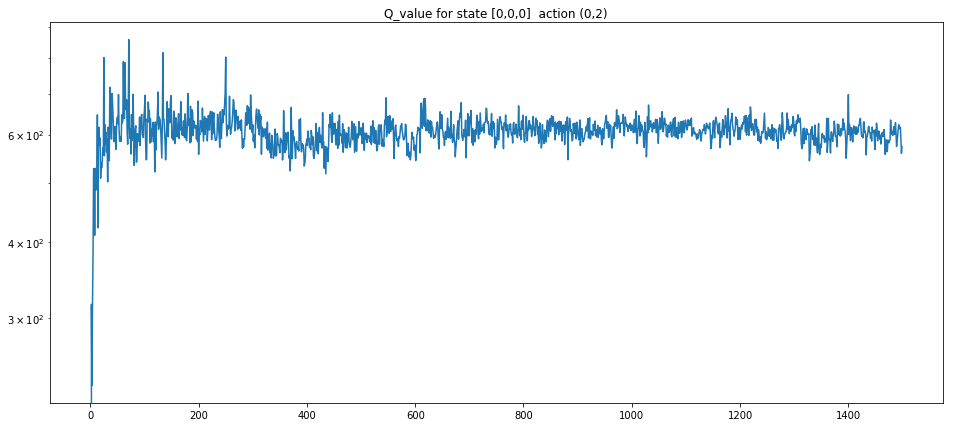

In [10]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

### Track rewards per episode

In [11]:
rewards_tracked = [rewards_per_episode[i] for i in range(len(rewards_per_episode)) if (i % 4 == 0)]

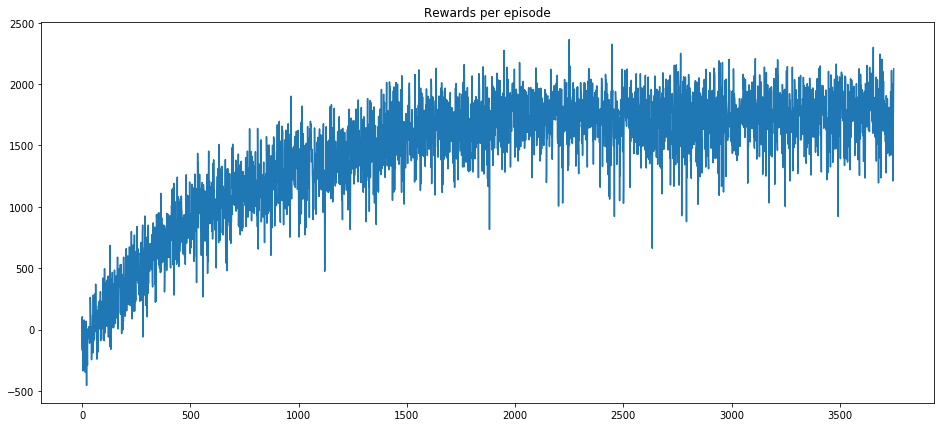

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_tracked)))
plt.plot(xaxis,np.asarray(rewards_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

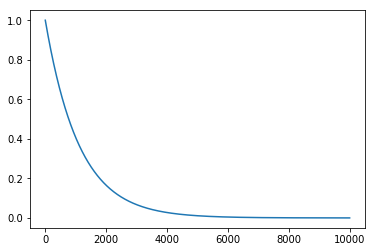

In [14]:
plt.plot(time, epsilon)
plt.show()